In [1]:

import os 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/Copy of Copy of FINAL_TRY_ZZZ.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Pediatric Chest X-ray Pneumonia/train/PNEUMONIA/person1400_bacteria_3550.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/PNEUMONIA/person1400_bacteria_3551.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/PNEUMONIA/person1400_bacteria_3553.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/PNEUMONIA/person1400_bacteria_3554.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/PNEUMONIA/person1401_bacteria_3555.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/PNEUMONIA/person1402_virus_2405.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/PNEUMONIA/person1403_bacteria_3557.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/PNEUMONIA/person1403_bacteria_3559.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/PNEUMONIA/person1403_virus_2406.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/PNEUMONIA/person1404_bacteria_3561.jpeg  
  inflating: Pediatric Ch

In [5]:
directory="/content/Pediatric Chest X-ray Pneumonia"
train_directory=os.path.join(directory,'train')
test_directory=os.path.join(directory,'test')
val_directory=os.path.join(directory,'val')

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory( train_directory, 
        classes = ['NORMAL', 'PNEUMONIA'],
        target_size=(128, 128),  
        batch_size=32,
        class_mode='binary')

# Flow validation images in batches of 32 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory( val_directory,
        classes = ['NORMAL', 'PNEUMONIA'],
        target_size=(128, 128), 
        batch_size=32,
        class_mode='binary',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(test_directory,
        classes = ['NORMAL', 'PNEUMONIA'],
        target_size=(128, 128), 
        batch_size=32,
        class_mode='binary',
        shuffle=False)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL=validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print("STEP_SIZE_TRAIN: ",STEP_SIZE_TRAIN)
print("STEP_SIZE_TEST: ",STEP_SIZE_TEST)

Found 7767 images belonging to 2 classes.
Found 1940 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
STEP_SIZE_TRAIN:  242
STEP_SIZE_TEST:  19


#MobileNet cr=32

## TRY FOR BOTH ratio = 16 and 32

In [7]:
def Squeeze_and_Excite_module(input_data,ratio=32):
  if(tf.keras.backend.image_data_format()=="channels_first"):
      channel_axis=1
  else:
      channel_axis=-1

  filters = input_data.shape[channel_axis]
  se_shape = (1, 1, filters)

  se_GP = tf.keras.layers.GlobalAveragePooling2D()(input_data)
  se_xxxxx = tf.keras.layers.Reshape(se_shape)(se_GP)
  
  se = Dense(filters, activation='sigmoid',  use_bias=False)(se_xxxxx)
  
  print(se.shape)
  print(se_xxxxx.shape)
  
  x = tf.keras.layers.Multiply()([se_xxxxx, se])

  x = Flatten()(x)

  return x

In [8]:
model_x = tf.keras.applications.MobileNet(include_top = False, weights="imagenet", input_shape=(128, 128,3))

17235968/17225924 [==============================] - 0s 0us/step


In [9]:
model_x = tf.keras.applications.MobileNet(include_top = False, weights="imagenet", input_shape=(128, 128,3))
fine_tune_at = len(model_x.layers)//2

for layer in model_x.layers[:fine_tune_at]:
    layer.trainable =  False


In [10]:
x1 = Squeeze_and_Excite_module(model_x.output)
dens= tf.keras.layers.Dense(512,activation='relu')(x1)
dp= tf.keras.layers.Dropout(0.4)(dens)

final_classification_layers = tf.keras.layers.Dense(1,activation='sigmoid')(dp)

(None, 1, 1, 1024)
(None, 1, 1, 1024)


In [11]:
R = keras.Model(model_x.input,final_classification_layers)

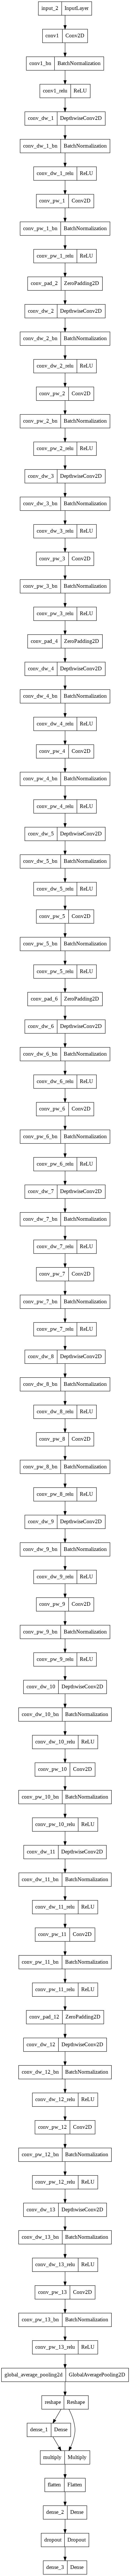

In [12]:
tf.keras.utils.plot_model(
    R,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [13]:
R.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['conv1_bn[0][0]']           

In [14]:
R.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = R.fit(train_generator,
steps_per_epoch=STEP_SIZE_TRAIN,
epochs=30,
verbose=1,
validation_data = validation_generator,
validation_steps=STEP_SIZE_VAL)    

Epoch 1/30
242/242 [==============================] - 181s 688ms/step - loss: 0.3990 - accuracy: 0.8252 - val_loss: 0.2749 - val_accuracy: 0.8896
Epoch 2/30
242/242 [==============================] - 140s 580ms/step - loss: 0.2171 - accuracy: 0.9180 - val_loss: 0.2469 - val_accuracy: 0.8979
Epoch 3/30
242/242 [==============================] - 139s 576ms/step - loss: 0.1682 - accuracy: 0.9365 - val_loss: 0.2435 - val_accuracy: 0.9000
Epoch 4/30
242/242 [==============================] - 139s 573ms/step - loss: 0.1433 - accuracy: 0.9444 - val_loss: 0.2426 - val_accuracy: 0.9031
Epoch 5/30
242/242 [==============================] - 139s 576ms/step - loss: 0.1374 - accuracy: 0.9483 - val_loss: 0.2421 - val_accuracy: 0.9057
Epoch 6/30
242/242 [==============================] - 156s 645ms/step - loss: 0.1178 - accuracy: 0.9566 - val_loss: 0.2603 - val_accuracy: 0.9005
Epoch 7/30
242/242 [==============================] - 139s 574ms/step - loss: 0.1078 - accuracy: 0.9604 - val_loss: 0.2672 -

20/20 [==============================] - 6s 262ms/step
Accuracy: 0.916667
Precision: 0.898585
Recall: 0.976923
F1 score: 0.936118
0.8965811965811965


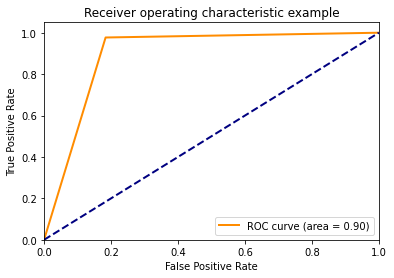

In [15]:
preds = R.predict(test_generator,verbose=1)
final_preds=[]
for i in preds:
    if(i >= 0.5):
        final_preds.append(1)
    else:
        final_preds.append(0)
accuracy = accuracy_score(list(test_generator.classes), final_preds)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(list(test_generator.classes), final_preds)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(list(test_generator.classes), final_preds)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(list(test_generator.classes), final_preds)
print('F1 score: %f' % f1)
fpr, tpr, _ = roc_curve(test_generator.classes, final_preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)
pr, tpr, _ = roc_curve(test_generator.classes, final_preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [16]:
history.history

{'accuracy': [0.8252100944519043,
  0.9180349111557007,
  0.9365223050117493,
  0.9444085359573364,
  0.9482870101928711,
  0.9565610885620117,
  0.9604395627975464,
  0.9594053030014038,
  0.9640594720840454,
  0.9659987092018127,
  0.9680672287940979,
  0.967291533946991,
  0.9705235958099365,
  0.9707821607589722,
  0.9714285731315613,
  0.9746606349945068,
  0.9722042679786682,
  0.9732385277748108,
  0.974531352519989,
  0.9734970927238464,
  0.9772462844848633,
  0.9769877195358276,
  0.9806076288223267,
  0.9772462844848633,
  0.981124758720398,
  0.9794440865516663,
  0.9804783463478088,
  0.9812540411949158,
  0.9806076288223267,
  0.9791855216026306],
 'loss': [0.3990389406681061,
  0.21710093319416046,
  0.1682099848985672,
  0.14329592883586884,
  0.13738545775413513,
  0.11783704161643982,
  0.10778816044330597,
  0.10744790732860565,
  0.10044960677623749,
  0.09211921691894531,
  0.08504526317119598,
  0.08559196442365646,
  0.08362086862325668,
  0.07916299998760223,
  

In [17]:
R.save("/content/drive/MyDrive/Models/mnet_cr32.h5")

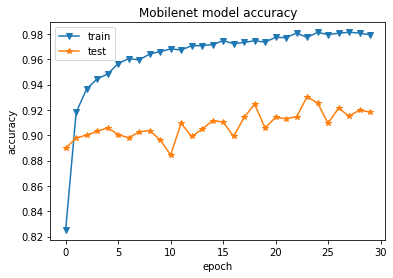

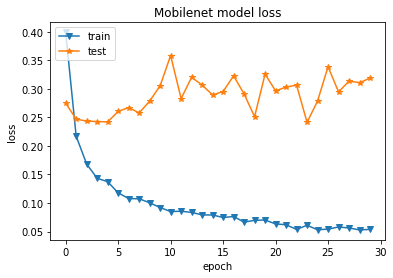

In [19]:
plt.plot(history.history['accuracy'],marker = 'v')
plt.plot(history.history['val_accuracy'],marker = '*')
plt.title('Mobilenet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'],marker = 'v')
plt.plot(history.history['val_loss'],marker = '*')
plt.title('Mobilenet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()